In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/CV project/

/content/drive/MyDrive/CV project


In [ ]:
#@title

import sys
import os
os.environ["HDF5_USE_FILE_LOCKING"]='FALSE'
import h5py
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import torch
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from display import get_cmap, vil_cmap, vis_cmap, ir_cmap, c09_cmap
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from model import SmaAt_UNet
import cv2
import torchvision.transforms as T
from torchvision import models, datasets, transforms
from tqdm import tqdm
from io import BytesIO
import copy
import torch.nn as nn
# importing libraries to implement style-transfer

from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sys.path.append('/content/drive/MyDrive/CV project/')

from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.patches as patches

In [ ]:
#@title
import torch
from torch import nn
import torch.nn.functional as F


# Taken from https://discuss.pytorch.org/t/is-there-any-layer-like-tensorflows-space-to-depth-function/3487/14
class DepthToSpace(nn.Module):

    def __init__(self, block_size):
        super().__init__()
        self.bs = block_size

    def forward(self, x):
        N, C, H, W = x.size()
        x = x.view(N, self.bs, self.bs, C // (self.bs ** 2), H, W)  # (N, bs, bs, C//bs^2, H, W)
        x = x.permute(0, 3, 4, 1, 5, 2).contiguous()  # (N, C//bs^2, H, bs, W, bs)
        x = x.view(N, C // (self.bs ** 2), H * self.bs, W * self.bs)  # (N, C//bs^2, H * bs, W * bs)
        return x


class SpaceToDepth(nn.Module):
    # Expects the following shape: Batch, Channel, Height, Width
    def __init__(self, block_size):
        super().__init__()
        self.bs = block_size

    def forward(self, x):
        N, C, H, W = x.size()
        x = x.view(N, C, H // self.bs, self.bs, W // self.bs, self.bs)  # (N, C, H//bs, bs, W//bs, bs)
        x = x.permute(0, 3, 5, 1, 2, 4).contiguous()  # (N, bs, bs, C, H//bs, W//bs)
        x = x.view(N, C * (self.bs ** 2), H // self.bs, W // self.bs)  # (N, C*bs^2, H//bs, W//bs)
        return x


class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, output_channels, kernel_size, padding=0, kernels_per_layer=1):
        super(DepthwiseSeparableConv, self).__init__()
        # In Tensorflow DepthwiseConv2D has depth_multiplier instead of kernels_per_layer
        self.depthwise = nn.Conv2d(in_channels, in_channels * kernels_per_layer, kernel_size=kernel_size, padding=padding,
                                   groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels * kernels_per_layer, output_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class DoubleDense(nn.Module):
    def __init__(self, in_channels, hidden_neurons, output_channels):
        super(DoubleDense, self).__init__()
        self.dense1 = nn.Linear(in_channels, out_features=hidden_neurons)
        self.dense2 = nn.Linear(in_features=hidden_neurons, out_features=hidden_neurons // 2)
        self.dense3 = nn.Linear(in_features=hidden_neurons // 2, out_features=output_channels)

    def forward(self, x):
        out = F.relu(self.dense1(x.view(x.size(0), -1)))
        out = F.relu(self.dense2(out))
        out = self.dense3(out)
        return out


class DoubleDSConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_ds_conv = nn.Sequential(
            DepthwiseSeparableConv(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_ds_conv(x)


class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)


class ChannelAttention(nn.Module):
    def __init__(self, input_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.input_channels = input_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        #  https://github.com/luuuyi/CBAM.PyTorch/blob/master/model/resnet_cbam.py
        #  uses Convolutions instead of Linear
        self.MLP = nn.Sequential(
            Flatten(),
            nn.Linear(input_channels, input_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(input_channels // reduction_ratio, input_channels)
        )

    def forward(self, x):
        # Take the input and apply average and max pooling
        avg_values = self.avg_pool(x)
        max_values = self.max_pool(x)
        out = self.MLP(avg_values) + self.MLP(max_values)
        scale = x * torch.sigmoid(out).unsqueeze(2).unsqueeze(3).expand_as(x)
        return scale


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(1)

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        out = self.bn(out)
        scale = x * torch.sigmoid(out)
        return scale


class CBAM(nn.Module):
    def __init__(self, input_channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(input_channels, reduction_ratio=reduction_ratio)
        self.spatial_att = SpatialAttention(kernel_size=kernel_size)

    def forward(self, x):
        out = self.channel_att(x)
        out = self.spatial_att(out)
        return out





""" Parts of the U-Net model """
# Base model taken from: https://github.com/milesial/Pytorch-UNet
import torch
import torch.nn as nn
import torch.nn.functional as F
#from models.layers import DepthwiseSeparableConv


class DoubleConvDS(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None, kernels_per_layer=1):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            DepthwiseSeparableConv(in_channels, mid_channels, kernel_size=3, kernels_per_layer=kernels_per_layer, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(mid_channels, out_channels, kernel_size=3, kernels_per_layer=kernels_per_layer, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class DownDS(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, kernels_per_layer=1):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConvDS(in_channels, out_channels, kernels_per_layer=kernels_per_layer)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class UpDS(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True, kernels_per_layer=1):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConvDS(in_channels, out_channels, in_channels // 2, kernels_per_layer=kernels_per_layer)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConvDS(in_channels, out_channels, kernels_per_layer=kernels_per_layer)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


from torch import nn
#from models.unet_parts import OutConv
#from models.unet_parts_depthwise_separable import DoubleConvDS, UpDS, DownDS
#from models.layers import CBAM


class SmaAt_UNet(nn.Module):
    def __init__(self, n_channels, n_classes, kernels_per_layer=2, bilinear=True, reduction_ratio=16):
        super(SmaAt_UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        kernels_per_layer = kernels_per_layer
        self.bilinear = bilinear
        reduction_ratio = reduction_ratio

        self.inc = DoubleConvDS(self.n_channels, 64, kernels_per_layer=kernels_per_layer)
        self.cbam1 = CBAM(64, reduction_ratio=reduction_ratio)
        self.down1 = DownDS(64, 128, kernels_per_layer=kernels_per_layer)
        self.cbam2 = CBAM(128, reduction_ratio=reduction_ratio)
        self.down2 = DownDS(128, 256, kernels_per_layer=kernels_per_layer)
        self.cbam3 = CBAM(256, reduction_ratio=reduction_ratio)
        self.down3 = DownDS(256, 512, kernels_per_layer=kernels_per_layer)
        self.cbam4 = CBAM(512, reduction_ratio=reduction_ratio)
        factor = 2 if self.bilinear else 1
        self.down4 = DownDS(512, 1024 // factor, kernels_per_layer=kernels_per_layer)
        self.cbam5 = CBAM(1024 // factor, reduction_ratio=reduction_ratio)
        self.up1 = UpDS(1024, 512 // factor, self.bilinear, kernels_per_layer=kernels_per_layer)
        self.up2 = UpDS(512, 256 // factor, self.bilinear, kernels_per_layer=kernels_per_layer)
        self.up3 = UpDS(256, 128 // factor, self.bilinear, kernels_per_layer=kernels_per_layer)
        self.up4 = UpDS(128, 64, self.bilinear, kernels_per_layer=kernels_per_layer)

        self.outc = OutConv(64, self.n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x1Att = self.cbam1(x1)
        x2 = self.down1(x1)
        x2Att = self.cbam2(x2)
        x3 = self.down2(x2)
        x3Att = self.cbam3(x3)
        x4 = self.down3(x3)
        x4Att = self.cbam4(x4)
        x5 = self.down4(x4)
        x5Att = self.cbam5(x5)
        x = self.up1(x5Att, x4Att)
        x = self.up2(x, x3Att)
        x = self.up3(x, x2Att)
        x = self.up4(x, x1Att)
        logits = self.outc(x)
        return logits

In [ ]:
## Load test data
data_path = 'data/'
DEST_TEST_FILE= os.path.join(data_path, 'nowcast_testing_000.h5')
N_TEST=500

with h5py.File(DEST_TEST_FILE,'r') as hf:
    Nr = N_TEST if N_TEST>=0 else hf['IN_vil'].shape[0]
    X_test = hf['IN_vil'][:Nr]
    Y_test = hf['OUT_vil'][:Nr]

In [ ]:
test_data = np.concatenate((X_test,Y_test),axis=3) ### IS AN NP ARRAY RIGHT NOW
del X_test
del Y_test

## Visualise a Test data example

Some of the test data examples are blank (ie. no real activity happening there) --> Remove them !!

2,3,4,5,10,11,12,13,18,26,27,32,34

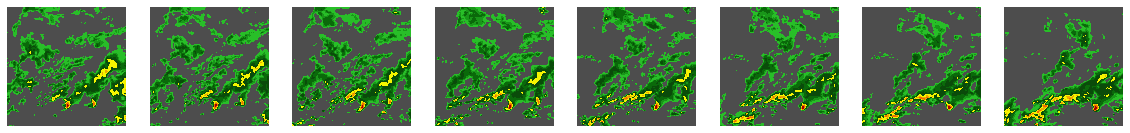

In [ ]:
img_index=6
cmap,norm,vmin,vmax=get_cmap('vil')
fig,axs=plt.subplots(1,8,figsize=(20,8))
for i in range(8):
    axs[i].imshow(test_data[img_index,:,:,3*i],origin='lower',cmap=cmap,norm=norm,vmin=vmin,vmax=vmax) 
    axs[i].set_axis_off()

In [ ]:
## COnvert data to torch tensor
test_data = torch.tensor(test_data)

In [ ]:
print("Testing data shape is: ", test_data.shape) 

Testing data shape is:  torch.Size([500, 384, 384, 25])


In [ ]:
#@title

## We need to use downsampled data for training our model because colab suxx

## input shape is = (n_egs, height, width, num_frames). For now height = width --> Is a torch tensor
## op_size is the height/width we would want our downsampled output to have
## sigma: The variance of the gaussian blur that we will apply to the images before downsampling


def blur_downsample(input, op_size, kernel_size=(5,5) ,sigma=(1,1)):
  
  n_egs, ip_h, ip_w, num_frames = input.shape 
  op = torch.zeros((n_egs, op_size, op_size, num_frames))

  # Define the blur transformation
  blur_transform = T.GaussianBlur(kernel_size=kernel_size, sigma=sigma)
  ds_transform = T.Resize((op_size,op_size))

  for eg in range(n_egs):
    cur_seq = input[eg,:,:,:]
    for frame_num in range(num_frames):
      cur_img = cur_seq[:,:,frame_num]

      ## First apply Gaussian blur to this image 
      cur_img_blrd = blur_transform(cur_img[None,:,:])
      
      ## Now downsample this blurred image
      cur_img_ds = ds_transform(cur_img_blrd)[0]
      op[eg,:,:,frame_num] = cur_img_ds 
  
  return op

In [ ]:
test_data = blur_downsample(test_data.float(), 192)

In [ ]:
torch.save(test_data, 'test_500_192.pt')

In [ ]:
test_data = torch.load('test_500_192.pt')

In [ ]:
#test_data = torch.load('test_500_25_96_96.pt')

In [ ]:
test_data.shape

torch.Size([500, 192, 192, 25])

In [ ]:
## Transpose test data to be able to be fed into model
test_data = torch.transpose(test_data, 2, 3)
test_data = torch.transpose(test_data, 1, 2).float()

In [ ]:
print("Shape of test data = ", test_data.shape)

Shape of test data =  torch.Size([500, 25, 192, 192])


In [ ]:
#@title
class SEVIR_Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, full_data):  # Full data shape is (n_egs, num_frames, height, width), includes X and Y
        'Initialization'
        self.X_egs = full_data[:,:13,:,:]
        self.Y_egs = full_data[:,13:,:,:]

  def __len__(self):
        'Denotes the total number of samples'
        return self.X_egs.shape[0]

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample

        # Load data and get label
        X = self.X_egs[index,:,:,:]
        y = self.Y_egs[index,:,:,:]

        return X, y

In [ ]:
norm_ = {'scale':47.54,'shift':33.44}
test_data = (test_data - norm_['shift'])/norm_['scale']

In [ ]:
## Set up testing data
X_test = test_data[:,:13,:,:] ; 
Y_test = test_data[:,13:,:,:] ; 

In [ ]:
test_dataset = SEVIR_Dataset(test_data) ; 

test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=4,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
    )

## Evaluation functions

In [ ]:
## 
# Functions for plotting results
##

norm_ = {'scale':47.54,'shift':33.44}
hmf_colors = np.array( [
    [82,82,82], 
    [252,141,89],
    [255,255,191],
    [145,191,219]
])/255

# Model that implements persistence forecast that just repeasts last frame of input
class persistence:
    def predict(self,x_test):
        return np.tile(x_test[:,-1:,:,:],[1,12,1,1])

def plot_hit_miss_fa(ax,y_true,y_pred,thres):       ## Takes input as numpy array
    mask = np.zeros_like(y_true)
    mask[np.logical_and(y_true>=thres,y_pred>=thres)]=4
    mask[np.logical_and(y_true>=thres,y_pred<thres)]=3
    mask[np.logical_and(y_true<thres,y_pred>=thres)]=2
    mask[np.logical_and(y_true<thres,y_pred<thres)]=1
    cmap=ListedColormap(hmf_colors)
    ax.imshow(mask,cmap=cmap)


def visualize_result(models,x_test,y_test,idx,ax,labels, thresh):
    fs=10
    cmap_dict = lambda s: {'cmap':get_cmap(s,encoded=True)[0],
                           'norm':get_cmap(s,encoded=True)[1],
                           'vmin':get_cmap(s,encoded=True)[2],
                           'vmax':get_cmap(s,encoded=True)[3]}
    for i in range(1,13,3):
        xt = (x_test[idx,i,:,:].detach().cpu())*norm_['scale']+norm_['shift']
        #xt = x_test[idx,i,:,:].detach().cpu() ; 
        #ax[(i-1)//3][0].imshow(xt,**cmap_dict('vil'))
        ax[(i-1)//3][0].imshow(xt,cmap=get_cmap('vil')[0])
    ax[0][0].set_title('Inputs',fontsize=fs)
    
    pers = persistence().predict(x_test[idx:idx+1])
    pers = pers*norm_['scale']+norm_['shift']
    x_test = x_test[idx:idx+1]
    y_test = y_test[idx:idx+1]*norm_['scale']+norm_['shift']
    y_preds=[]
    for i,m in enumerate(models):
        #yp = m.predict(x_test)        ### CHANGE THIS LINE !!!  --> See shapes of X_test, Y_test --> Might be different for different models
        m.eval() ; 
        yp = m(x_test.to(device)).cpu().detach().numpy() ; 
        if isinstance(yp,(list,)):
            yp=yp[0]
        y_preds.append(yp*norm_['scale']+norm_['shift'])
        #print("TESTING HERE0: ", yp.shape)
    
    for i in range(0,12,3):
        ax[i//3][2].imshow(y_test[0,i,:,:].numpy(),**cmap_dict('vil'))  ## Change this line --> CHANGED 
    ax[0][2].set_title('Target',fontsize=fs)
    
    # Plot Persistence
    for i in range(0,12,3):
        #print("TESTING HERE1: ", y_test.shape)
        #print("TESTING HERE2: ", pers.shape)
        plot_hit_miss_fa(ax[i//3][4],y_test[0,i,:,:].numpy(),pers[0,i,:,:],thresh)    ## Change this LINE --> ALSO make threshold a variable value
    ax[0][4].set_title('Persistence\nScores',fontsize=fs)
    
    for k,m in enumerate(models):
        for i in range(0,12,3):
            ax[i//3][5+2*k].imshow(y_preds[k][0,i,:,:],**cmap_dict('vil'))
            plot_hit_miss_fa(ax[i//3][5+2*k+1],y_test[0,i,:,:].numpy(),y_preds[k][0,i,:,:],thresh)  ## CHANGE THIS LINE, based on shapes of inputs and outputs

        ax[0][5+2*k].set_title(labels[k],fontsize=fs)
        ax[0][5+2*k+1].set_title(labels[k]+'\nScores',fontsize=fs)
        
    for j in range(len(ax)):
        for i in range(len(ax[j])):
            ax[j][i].xaxis.set_ticks([])
            ax[j][i].yaxis.set_ticks([])
    for i in range(4):
        ax[i][1].set_visible(False)
    for i in range(4):
        ax[i][3].set_visible(False)
    ax[0][0].set_ylabel('-45 Minutes')
    ax[1][0].set_ylabel('-30 Minutes')
    ax[2][0].set_ylabel('-15 Minutes')
    ax[3][0].set_ylabel('  0 Minutes')
    ax[0][2].set_ylabel('+15 Minutes')
    ax[1][2].set_ylabel('+30 Minutes')
    ax[2][2].set_ylabel('+45 Minutes')
    ax[3][2].set_ylabel('+60 Minutes')
    
    legend_elements = [Patch(facecolor=hmf_colors[1], edgecolor='k', label='False Alarm'),
                   Patch(facecolor=hmf_colors[2], edgecolor='k', label='Miss'),
                   Patch(facecolor=hmf_colors[3], edgecolor='k', label='Hit')]
    ax[-1][-1].legend(handles=legend_elements, loc='lower right', bbox_to_anchor= (-5.4, -.35), 
                           ncol=5, borderaxespad=0, frameon=False, fontsize='16')
    plt.subplots_adjust(hspace=0.05, wspace=0.05)

In [ ]:
## Y_test and Y_pred are (#samples, #frames, H,W) shaped --> Neither on GPU, but input as torch tensors
def get_eval_metrics(y_pred,y_true,thres):
  y_pred = y_pred.numpy()
  y_true = y_true.numpy()
  total_mask = np.zeros_like(y_true) ; 
  
  results_dict = {}
  results_dict['POD'] = [] ; 
  results_dict['SUCR'] = [] ; 
  results_dict['CSI'] = [] ; 
  results_dict['Bias'] = [] ; 
  results_dict['MSE'] = [] ; 

  for frame_num in range(y_true.shape[1]):
    for idx in range(y_true.shape[0]):

      # print("Frame number = ", frame_num)
      # print("IDX = ", idx)

      mask = np.zeros_like(y_true[0,0,:,:])
      y_pred_ = y_pred[idx,frame_num,:,:]
      y_true_ = y_true[idx,frame_num,:,:]
      mask[np.logical_and(y_true_>=thres,y_pred_>=thres)]=4
      mask[np.logical_and(y_true_>=thres,y_pred_<thres)]=3
      mask[np.logical_and(y_true_<thres,y_pred_>=thres)]=2
      mask[np.logical_and(y_true_<thres,y_pred_<thres)]=1

      total_mask[idx,frame_num,:,:] = mask 


    hits_ = np.count_nonzero(total_mask[:,frame_num,:,:]==4)
    miss_ = np.count_nonzero(total_mask[:,frame_num,:,:]==3)
    false_al_ = np.count_nonzero(total_mask[:,frame_num,:,:]==2)
    true_neg_ = np.count_nonzero(total_mask[:,frame_num,:,:]==1) 
    # print("HITS", hits_)
    # print("MISS", miss_)
    # print("FA", false_al_)
    # print("TN", true_neg_)

    #print("START", results_dict)
    results_dict['POD'].append((hits_/(hits_+miss_)))
    results_dict['SUCR'].append((hits_/(hits_+false_al_)))
    results_dict['CSI'].append((hits_/(hits_+miss_+false_al_)))
    results_dict['Bias'].append((hits_+false_al_/(hits_+miss_)))
    #mse = torch.nn.MSELoss() ; 
    #results_dict['MSE'].append((1/())*torch.sum((y_true[:,frame_num,:,:] - y_pred[:,frame_num,:,:])**2))
    #print("END", results_dict)


  hits = np.count_nonzero(total_mask==4)
  miss = np.count_nonzero(total_mask==3)
  false_al = np.count_nonzero(total_mask==2)
  true_neg = np.count_nonzero(total_mask==1)

  
  results_dict['POD_total'] = hits/(hits+miss) ; 
  results_dict['SUCR_total'] = hits/(hits+false_al) ; 
  results_dict['CSI_total'] = hits/(hits+miss+false_al) ; 
  results_dict['Bias_total'] = (hits+false_al)/(hits+miss) ; 


  return total_mask, results_dict

In [ ]:
## Set up testing data
X_test = test_data[:,:13,:,:] ; 
Y_test = test_data[:,13:,:,:] ; 

In [ ]:
del test_data

In [ ]:
X_test.max()

tensor(4.6395)

In [ ]:
## Define function to run all of the test data into the model

def get_preds(model, dataloader):

  op = torch.tensor([]) ; 
  model.eval()
  batches = tqdm(enumerate(dataloader), total=len(dataloader))
  for batch_idx, (data, target) in batches:
    # Move data to GPU
    data = data.to(device)
    #target = target.to(device)
    op_curr = model(data).detach().cpu()*norm_['scale']+norm_['shift']
    op = torch.cat((op,op_curr),0)
  
  return op

## Read in relevant models and set-up models list to be evaluated

In [ ]:
# u_net1 = SmaAt_UNet(n_channels=13 , n_classes=12) ;
# u_net1 = u_net1.to(device) ; 
# u_net1.load_state_dict(torch.load('u_net_alpha_0.5.pt')) ; 

# u_net2 = SmaAt_UNet(n_channels=13 , n_classes=12) ;
# u_net2 = u_net2.to(device) ; 
# u_net2.load_state_dict(torch.load('u_net_alpha_0.75.pt')) ; 

# u_net3 = SmaAt_UNet(n_channels=13 , n_classes=12) ;
# u_net3 = u_net3.to(device) ; 
# u_net3.load_state_dict(torch.load('u_net_alpha_0.25.pt')) ; 

u_net4 = SmaAt_UNet(n_channels=13 , n_classes=12) ;
u_net4 = u_net4.to(device) ; 
u_net4.load_state_dict(torch.load('u_net_alpha_0.pt')) ; 

u_net5 = SmaAt_UNet(n_channels=13 , n_classes=12) ;
u_net5 = u_net5.to(device) ; 
u_net5.load_state_dict(torch.load('u_net_alpha_1.pt')) ; 



# u_net4 = SmaAt_UNet(n_channels=13 , n_classes=12) ;
# u_net4 = u_net4.to(device) ; 
# u_net4.load_state_dict(torch.load('u_net_alpha_0.75.pt')) ; 

### ADD OTHER MODELS THAT WILL BE TRAINED OVER HERE !

In [ ]:
import json

In [ ]:
models = [u_net4, u_net5]#, u_net4]   ## ADD OTHER MODELS TO BE EVAKLUATED TO THIS LIST!!

In [ ]:
X_test.max()

tensor(4.6395)

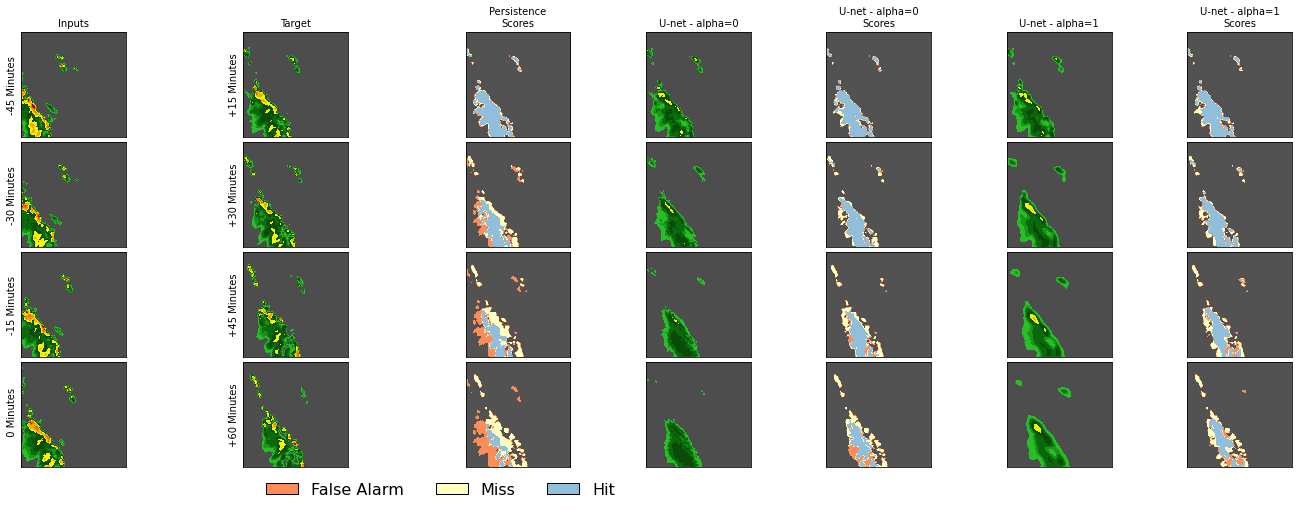

In [ ]:
idx=8 # adjust this to pick a case
fig,ax = plt.subplots(4,9,figsize=(24,8), gridspec_kw={'width_ratios': [1,.2,1,.2,1,1,1,1,1]})
visualize_result(models,X_test,Y_test,idx,ax,labels=['U-net - alpha=0', 'U-net - alpha=1'], thresh=74)

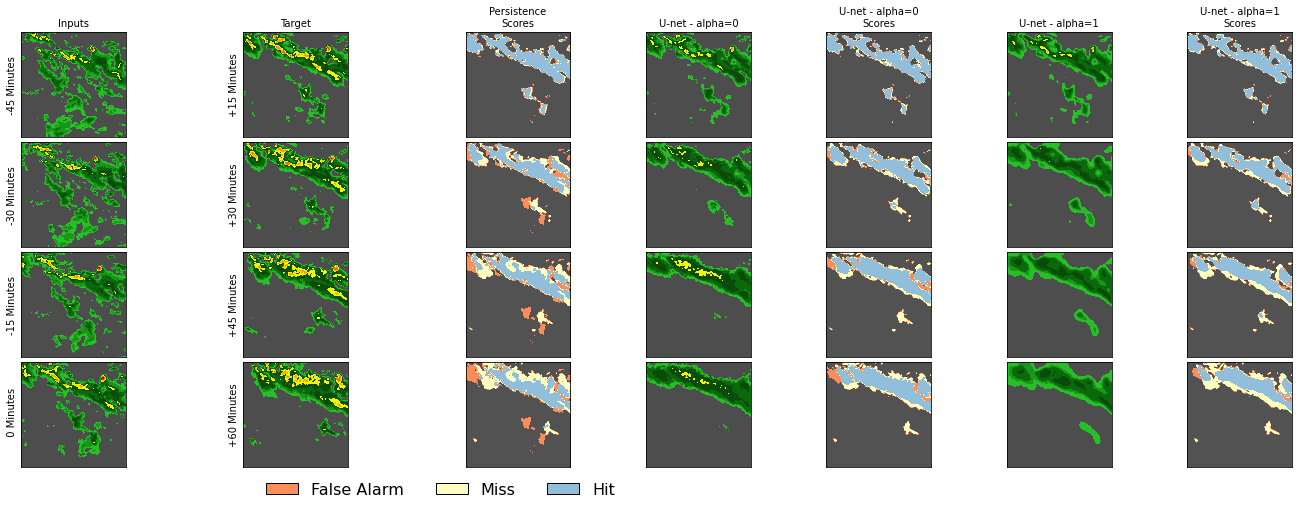

In [ ]:
idx=14 # adjust this to pick a case
fig,ax = plt.subplots(4,9,figsize=(24,8), gridspec_kw={'width_ratios': [1,.2,1,.2,1,1,1,1,1]})
visualize_result(models,X_test,Y_test,idx,ax,labels=['U-net - alpha=0', 'U-net - alpha=1'], thresh=74)

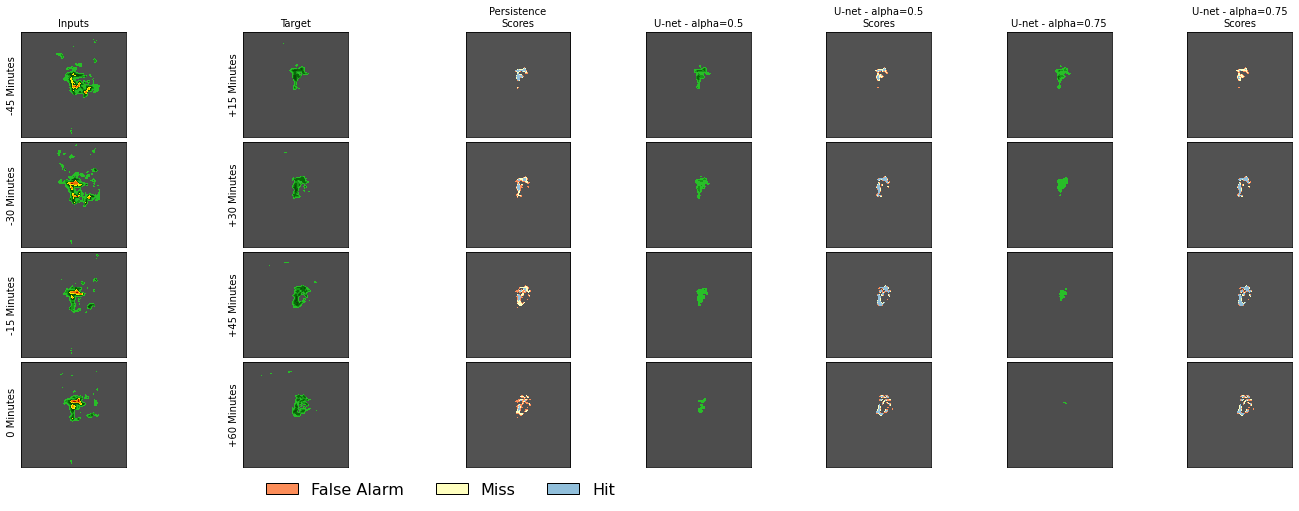

In [ ]:
idx=15 # adjust this to pick a case
fig,ax = plt.subplots(4,9,figsize=(24,8), gridspec_kw={'width_ratios': [1,.2,1,.2,1,1,1,1,1]})
visualize_result(models,X_test,Y_test,idx,ax,labels=['U-net - alpha=0.5', 'U-net - alpha=0.75'], thresh=74)

## Evaluation metric plots - 74

In [ ]:
## Model 1
Y_pred1 = get_preds(u_net1, test_dataloader) ; 

m16_1, res_dict16_1 = get_eval_metrics(Y_pred1, (Y_test*norm_['scale']+norm_['shift']), 16) ; 
m74_1, res_dict74_1 = get_eval_metrics(Y_pred1, (Y_test*norm_['scale']+norm_['shift']), 74) ; 
m133_1, res_dict133_1 = get_eval_metrics(Y_pred1, (Y_test*norm_['scale']+norm_['shift']), 133) ; 

del Y_pred1


100%|██████████| 125/125 [00:23<00:00,  5.32it/s]


In [ ]:
import json

In [ ]:
with open('results_unet0_5_16.json', 'w') as fp:
    json.dump(res_dict16_1, fp)

with open('results_unet0_5_74.json', 'w') as fp:
    json.dump(res_dict74_1, fp)

with open('results_unet0_5_133.json', 'w') as fp:
    json.dump(res_dict133_1, fp)

In [ ]:
del m16_1, m74_1, m133_1

In [ ]:
Y_pred2 = get_preds(u_net2, test_dataloader) ; 

m16_2, res_dict16_2 = get_eval_metrics(Y_pred2, (Y_test*norm_['scale']+norm_['shift']), 16) ; 
m74_2, res_dict74_2 = get_eval_metrics(Y_pred2, (Y_test*norm_['scale']+norm_['shift']), 74) ; 
m133_2, res_dict133_2 = get_eval_metrics(Y_pred2, (Y_test*norm_['scale']+norm_['shift']), 133) ; 

del Y_pred2

100%|██████████| 125/125 [00:25<00:00,  4.91it/s]


In [ ]:
with open('results_unet0_75_16.json', 'w') as fp:
    json.dump(res_dict16_2, fp)

with open('results_unet0_75_74.json', 'w') as fp:
    json.dump(res_dict74_2, fp)

with open('results_unet0_75_133.json', 'w') as fp:
    json.dump(res_dict133_2, fp)

In [ ]:
del m16_2, m74_2, m133_2

In [ ]:
Y_pred3 = get_preds(u_net3, test_dataloader) ; 

m16_3, res_dict16_3 = get_eval_metrics(Y_pred3, (Y_test*norm_['scale']+norm_['shift']), 16) ; 
m74_3, res_dict74_3 = get_eval_metrics(Y_pred3, (Y_test*norm_['scale']+norm_['shift']), 74) ; 
m133_3, res_dict133_3 = get_eval_metrics(Y_pred3, (Y_test*norm_['scale']+norm_['shift']), 133) ;

del Y_pred3

100%|██████████| 125/125 [00:25<00:00,  4.95it/s]


In [ ]:
with open('results_unet0_25_16.json', 'w') as fp:
    json.dump(res_dict16_3, fp)

with open('results_unet0_25_74.json', 'w') as fp:
    json.dump(res_dict74_3, fp)

with open('results_unet0_25_133.json', 'w') as fp:
    json.dump(res_dict133_3, fp)

In [ ]:
del m16_3, m74_3, m133_3

In [ ]:
Y_pred4 = get_preds(u_net4, test_dataloader) ; 

m16_4, res_dict16_4 = get_eval_metrics(Y_pred4, (Y_test*norm_['scale']+norm_['shift']), 16) ; 
m74_4, res_dict74_4 = get_eval_metrics(Y_pred4, (Y_test*norm_['scale']+norm_['shift']), 74) ; 
m133_4, res_dict133_4 = get_eval_metrics(Y_pred4, (Y_test*norm_['scale']+norm_['shift']), 133) ; 

del Y_pred4 

100%|██████████| 125/125 [00:27<00:00,  4.57it/s]


In [ ]:
with open('results_unet0_16.json', 'w') as fp:
    json.dump(res_dict16_4, fp)

with open('results_unet0_74.json', 'w') as fp:
    json.dump(res_dict74_4, fp)

with open('results_unet0_133.json', 'w') as fp:
    json.dump(res_dict133_4, fp)

In [ ]:
Y_pred5 = get_preds(u_net5, test_dataloader) ; 

m16_5, res_dict16_5 = get_eval_metrics(Y_pred5, (Y_test*norm_['scale']+norm_['shift']), 16) ; 
m74_5, res_dict74_5 = get_eval_metrics(Y_pred5, (Y_test*norm_['scale']+norm_['shift']), 74) ; 
m133_5, res_dict133_5 = get_eval_metrics(Y_pred5, (Y_test*norm_['scale']+norm_['shift']), 133) ; 

del Y_pred5

100%|██████████| 125/125 [00:27<00:00,  4.61it/s]


In [ ]:
del m16_5, m74_5, m133_5

In [ ]:
with open('results_unet1_16.json', 'w') as fp:
    json.dump(res_dict16_5, fp)

with open('results_unet1_74.json', 'w') as fp:
    json.dump(res_dict74_5, fp)

with open('results_unet1_133.json', 'w') as fp:
    json.dump(res_dict133_5, fp)

In [ ]:
ar1 = Y_test[0,0,:,:]*norm_['scale']+norm_['shift']

NameError: ignored

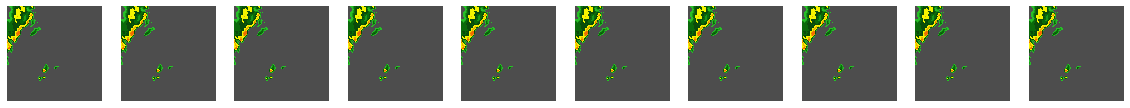

In [ ]:
img_index=5
cmap,norm,vmin,vmax=get_cmap('vil')
fig,axs=plt.subplots(1,10,figsize=(20,8))
for i in range(10):
    axs[i].imshow(tr1,origin='lower',cmap=cmap,norm=norm,vmin=vmin,vmax=vmax) 
    axs[i].set_axis_off()

In [ ]:
X_test.max()

tensor(4.6395)

In [ ]:
pr1 = Y_pred1[0,0,:,:]

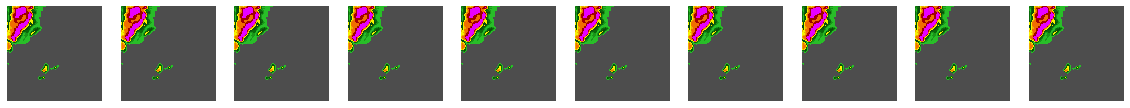

In [ ]:
img_index=5
cmap,norm,vmin,vmax=get_cmap('vil')
fig,axs=plt.subplots(1,10,figsize=(20,8))
for i in range(10):
    axs[i].imshow(pr1,origin='lower',cmap=cmap,norm=norm,vmin=vmin,vmax=vmax) 
    axs[i].set_axis_off()

In [ ]:
m16_1, res_dict16_1 = get_eval_metrics(Y_pred1, (Y_test*norm_['scale']+norm_['shift']), 16) ; 
m74_1, res_dict74_1 = get_eval_metrics(Y_pred1, (Y_test*norm_['scale']+norm_['shift']), 74) ; 
m133_1, res_dict133_1 = get_eval_metrics(Y_pred1, (Y_test*norm_['scale']+norm_['shift']), 133) ; 
# m160_1, res_dict160_1 = get_eval_metrics(Y_pred1, (Y_test*norm_['scale']+norm_['shift']), 160) ; 
#m181_1, res_dict181_1 = get_eval_metrics(Y_pred1, (Y_test*norm_['scale']+norm_['shift']), 181) ; 

del Y_pred1

m16_2, res_dict16_2 = get_eval_metrics(Y_pred2, (Y_test*norm_['scale']+norm_['shift']), 16) ; 
m74_2, res_dict74_2 = get_eval_metrics(Y_pred2, (Y_test*norm_['scale']+norm_['shift']), 74) ; 
m133_2, res_dict133_2 = get_eval_metrics(Y_pred2, (Y_test*norm_['scale']+norm_['shift']), 133) ; 
# m160_2, res_dict160_2 = get_eval_metrics(Y_pred2, (Y_test*norm_['scale']+norm_['shift']), 160) ; 
# m181_2, res_dict181_2 = get_eval_metrics(Y_pred2, (Y_test*norm_['scale']+norm_['shift']), 181) ; 
# m219, res_dict219 = get_eval_metrics(Y_pred1, (Y_test*norm['scale']+norm['shift']), 219) ; 

del Y_pred2

m16_3, res_dict16_3 = get_eval_metrics(Y_pred3, (Y_test*norm_['scale']+norm_['shift']), 16) ; 
m74_3, res_dict74_3 = get_eval_metrics(Y_pred3, (Y_test*norm_['scale']+norm_['shift']), 74) ; 
m133_3, res_dict133_3 = get_eval_metrics(Y_pred3, (Y_test*norm_['scale']+norm_['shift']), 133) ; 

del Y_pred3

m16_4, res_dict16_4 = get_eval_metrics(Y_pred4, (Y_test*norm_['scale']+norm_['shift']), 16) ; 
m74_4, res_dict74_4 = get_eval_metrics(Y_pred4, (Y_test*norm_['scale']+norm_['shift']), 74) ; 
m133_4, res_dict133_4 = get_eval_metrics(Y_pred4, (Y_test*norm_['scale']+norm_['shift']), 133) ; 

del Y_pred4

In [ ]:
m133_3, res_dict133_3 = get_eval_metrics(Y_pred3, (Y_test*norm_['scale']+norm_['shift']), 133) ; 

In [ ]:
import json

In [ ]:
# with open('results_unet_16.json', 'w') as fp:
#     json.dump(res_dict16, fp)

# with open('results_unet_74.json', 'w') as fp:
#     json.dump(res_dict74, fp)

# with open('results_unet_133.json', 'w') as fp:
#     json.dump(res_dict133, fp)

# with open('results_unet_160.json', 'w') as fp:
#     json.dump(res_dict160, fp)

# with open('results_unet_181.json', 'w') as fp:
#     json.dump(res_dict181, fp)

In [ ]:
with open('results_unet0_5_16.json') as json_file:
    res_dict16_1 = json.load(json_file)

with open('results_unet0_5_74.json') as json_file:
    res_dict74_1 = json.load(json_file)

with open('results_unet0_5_133.json') as json_file:
    res_dict133_1 = json.load(json_file)

with open('results_unet0_75_16.json') as json_file:
    res_dict16_2 = json.load(json_file)

with open('results_unet0_75_74.json') as json_file:
    res_dict74_2 = json.load(json_file)

with open('results_unet0_75_133.json') as json_file:
    res_dict133_2 = json.load(json_file)

with open('results_unet0_25_16.json') as json_file:
    res_dict16_3 = json.load(json_file)

with open('results_unet0_25_74.json') as json_file:
    res_dict74_3 = json.load(json_file)

with open('results_unet0_25_133.json') as json_file:
    res_dict133_3 = json.load(json_file)

with open('results_unet0_16.json') as json_file:
    res_dict16_4 = json.load(json_file)

with open('results_unet0_74.json') as json_file:
    res_dict74_4 = json.load(json_file)

with open('results_unet0_133.json') as json_file:
    res_dict133_4 = json.load(json_file)

with open('results_unet1_16.json') as json_file:
    res_dict16_5 = json.load(json_file)

with open('results_unet1_74.json') as json_file:
    res_dict74_5 = json.load(json_file)

with open('results_unet1_133.json') as json_file:
    res_dict133_5 = json.load(json_file)

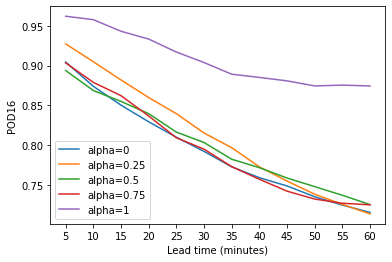

In [ ]:
plt.figure()
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict16_4['POD'], label='alpha=0')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict16_3['POD'], label='alpha=0.25')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict16_1['POD'], label='alpha=0.5')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict16_2['POD'], label='alpha=0.75')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict16_5['POD'], label='alpha=1')


plt.legend()
#plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict74['POD'])
# plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict133['POD'])
# plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict160['POD'])
# ADD RESULTS FROM ALL THE OTHER MODELS HERE 
plt.ylabel("POD16")
plt.xlabel("Lead time (minutes)")
plt.xticks([5,10,15,20,25,30,35,40,45,50,55,60]) ; 

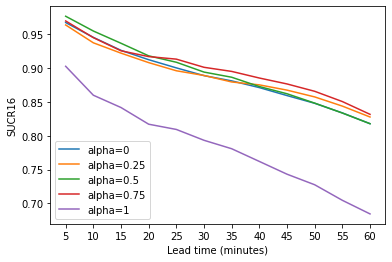

In [ ]:
plt.figure()
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict16_4['SUCR'], label='alpha=0')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict16_3['SUCR'], label='alpha=0.25')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict16_1['SUCR'], label='alpha=0.5')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict16_2['SUCR'], label='alpha=0.75')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict16_5['SUCR'], label='alpha=1')

plt.legend()
# plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict74['SUCR'])
# plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict133['SUCR'])
# plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict160['SUCR'])


# ADD RESULTS FROM ALL THE OTHER MODELS HERE 
plt.ylabel("SUCR16")
plt.xlabel("Lead time (minutes)")
plt.xticks([5,10,15,20,25,30,35,40,45,50,55,60]) ; 

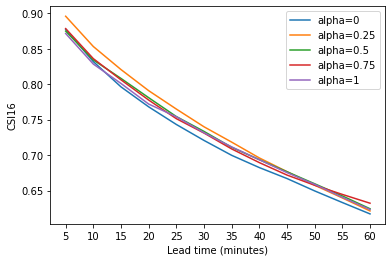

In [ ]:
plt.figure()
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict16_4['CSI'], label='alpha=0')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict16_3['CSI'], label='alpha=0.25')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict16_1['CSI'], label='alpha=0.5')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict16_2['CSI'], label='alpha=0.75')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict16_5['CSI'], label='alpha=1')
plt.legend()
# ADD RESULTS FROM ALL THE OTHER MODELS HERE 
plt.ylabel("CSI16")
plt.xlabel("Lead time (minutes)")
plt.xticks([5,10,15,20,25,30,35,40,45,50,55,60]) ; 

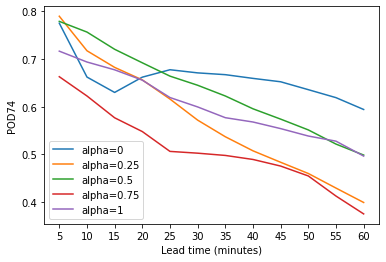

In [ ]:
plt.figure()
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict74_4['POD'], label='alpha=0')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict74_3['POD'], label='alpha=0.25')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict74_1['POD'], label='alpha=0.5')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict74_2['POD'], label='alpha=0.75')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict74_5['POD'], label='alpha=1')
plt.legend()
# ADD RESULTS FROM ALL THE OTHER MODELS HERE 
plt.ylabel("POD74")
plt.xlabel("Lead time (minutes)")
plt.xticks([5,10,15,20,25,30,35,40,45,50,55,60]) ; 

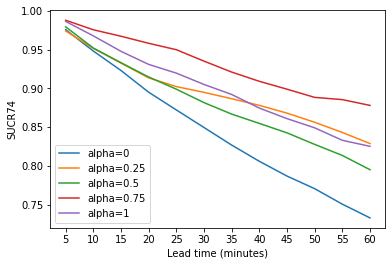

In [ ]:
plt.figure()
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict74_4['SUCR'], label='alpha=0')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict74_3['SUCR'], label='alpha=0.25')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict74_1['SUCR'], label='alpha=0.5')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict74_2['SUCR'], label='alpha=0.75')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict74_5['SUCR'], label='alpha=1')

plt.legend()
# ADD RESULTS FROM ALL THE OTHER MODELS HERE 
plt.ylabel("SUCR74")
plt.xlabel("Lead time (minutes)")
plt.xticks([5,10,15,20,25,30,35,40,45,50,55,60]) ; 

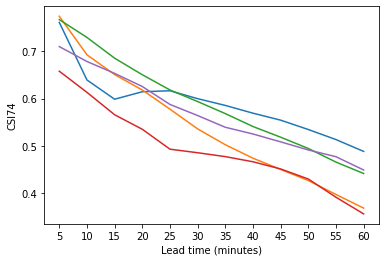

In [ ]:
plt.figure()
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict74_4['CSI'], label='alpha=0')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict74_3['CSI'], label='alpha=0.25')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict74_1['CSI'], label='alpha=0.5')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict74_2['CSI'], label='alpha=0.75')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict74_5['CSI'], label='alpha=1')
# ADD RESULTS FROM ALL THE OTHER MODELS HERE 
plt.ylabel("CSI74")
plt.xlabel("Lead time (minutes)")
plt.xticks([5,10,15,20,25,30,35,40,45,50,55,60]) ; 

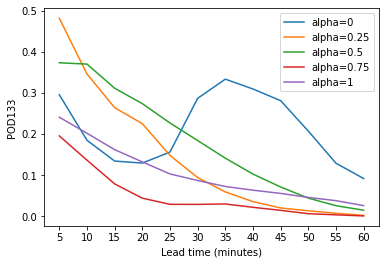

In [ ]:
plt.figure()
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict133_4['POD'], label='alpha=0')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict133_3['POD'], label='alpha=0.25')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict133_1['POD'], label='alpha=0.5')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict133_2['POD'], label='alpha=0.75')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict133_5['POD'], label='alpha=1')
plt.legend()
# ADD RESULTS FROM ALL THE OTHER MODELS HERE 
plt.ylabel("POD133")
plt.xlabel("Lead time (minutes)")
plt.xticks([5,10,15,20,25,30,35,40,45,50,55,60]) ; 

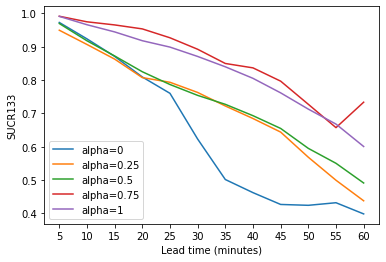

In [ ]:
plt.figure()
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict133_4['SUCR'], label='alpha=0')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict133_3['SUCR'], label='alpha=0.25')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict133_1['SUCR'], label='alpha=0.5')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict133_2['SUCR'], label='alpha=0.75')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict133_5['SUCR'], label='alpha=1')
plt.legend()

# ADD RESULTS FROM ALL THE OTHER MODELS HERE 
plt.ylabel("SUCR133")
plt.xlabel("Lead time (minutes)")
plt.xticks([5,10,15,20,25,30,35,40,45,50,55,60]) ; 

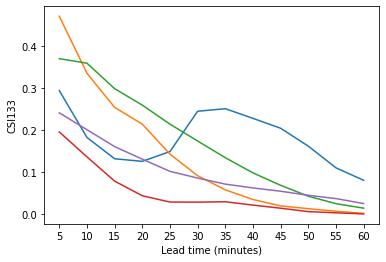

In [ ]:
plt.figure()
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict133_4['CSI'], label='alpha=0')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict133_3['CSI'], label='alpha=0.25')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict133_1['CSI'], label='alpha=0.5')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict133_2['CSI'], label='alpha=0.75')
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict133_5['CSI'], label='alpha=1')
# ADD RESULTS FROM ALL THE OTHER MODELS HERE 
plt.ylabel("CSI133")
plt.xlabel("Lead time (minutes)")
plt.xticks([5,10,15,20,25,30,35,40,45,50,55,60]) ; 

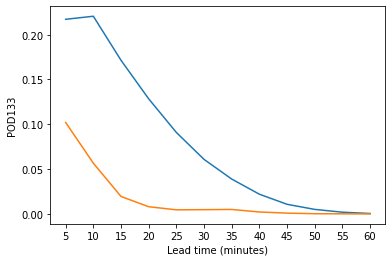

In [ ]:
plt.figure()
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict160_1['POD'])
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict160_2['POD'])
# ADD RESULTS FROM ALL THE OTHER MODELS HERE 
plt.ylabel("POD133")
plt.xlabel("Lead time (minutes)")
plt.xticks([5,10,15,20,25,30,35,40,45,50,55,60]) ; 

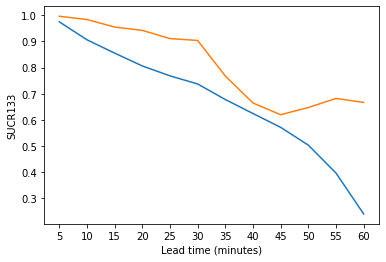

In [ ]:
plt.figure()
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict160_1['SUCR'])
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict160_2['SUCR'])
# ADD RESULTS FROM ALL THE OTHER MODELS HERE 
plt.ylabel("SUCR133")
plt.xlabel("Lead time (minutes)")
plt.xticks([5,10,15,20,25,30,35,40,45,50,55,60]) ; 

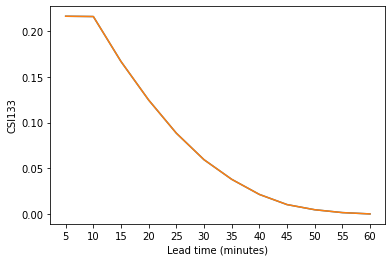

In [ ]:
plt.figure()
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict160_1['CSI'])
plt.plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict160_2['CSI'])
# ADD RESULTS FROM ALL THE OTHER MODELS HERE 
plt.ylabel("CSI133")
plt.xlabel("Lead time (minutes)")
plt.xticks([5,10,15,20,25,30,35,40,45,50,55,60]) ; 

Text(0.5, 0, 'Lead time')

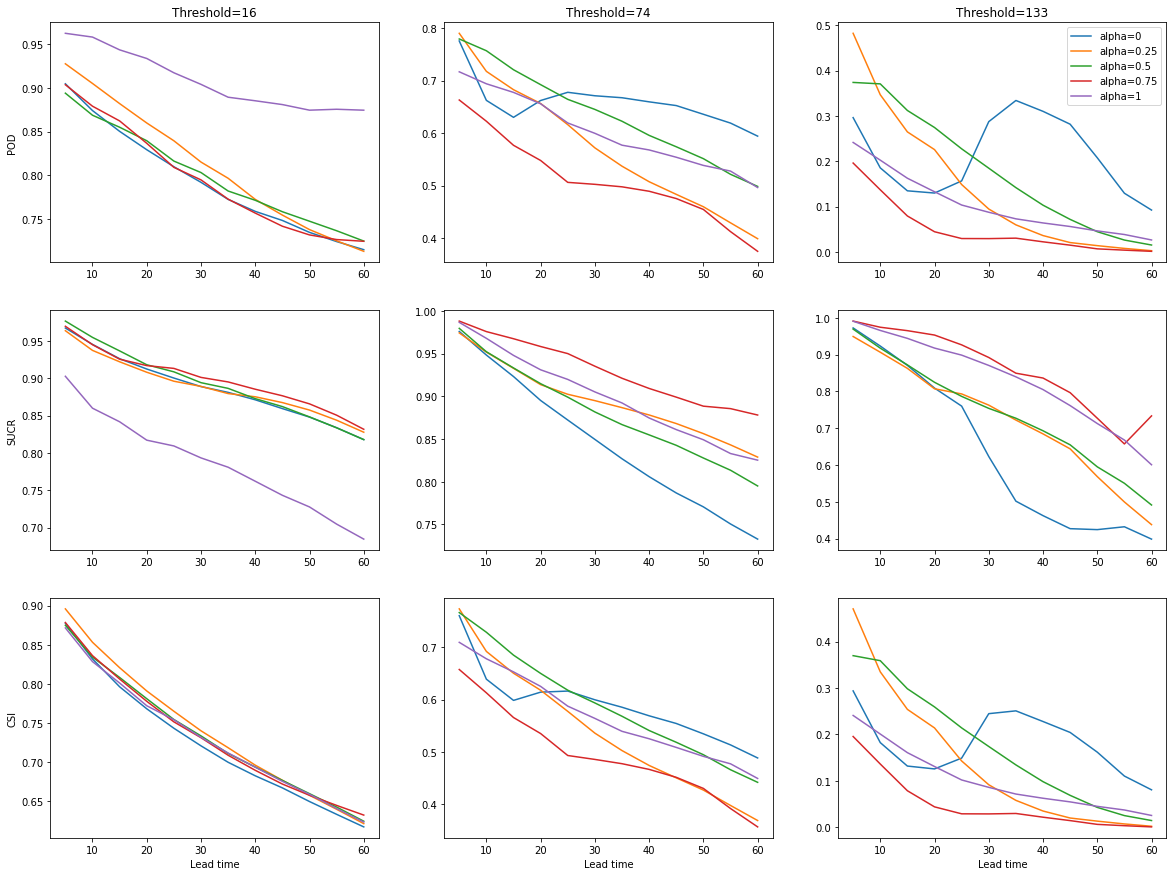

In [ ]:
fig,axs=plt.subplots(3,3,figsize=(20,15))

axs[0][0].set_ylabel("POD")
axs[0][0].plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict16_4['POD'],label='alpha=0')
axs[0][0].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict16_3['POD'], label='alpha=0.25')
axs[0][0].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict16_1['POD'], label='alpha=0.5')
axs[0][0].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict16_2['POD'], label='alpha=0.75')
axs[0][0].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict16_5['POD'], label='alpha=1')


axs[0][1].plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict74_4['POD'],label='alpha=0')
axs[0][1].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict74_3['POD'], label='alpha=0.25')
axs[0][1].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict74_1['POD'], label='alpha=0.5')
axs[0][1].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict74_2['POD'], label='alpha=0.75')
axs[0][1].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict74_5['POD'], label='alpha=1')

axs[0][2].plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict133_4['POD'],label='alpha=0')
axs[0][2].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict133_3['POD'], label='alpha=0.25')
axs[0][2].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict133_1['POD'], label='alpha=0.5')
axs[0][2].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict133_2['POD'], label='alpha=0.75')
axs[0][2].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict133_5['POD'], label='alpha=1')


axs[1][0].set_ylabel("SUCR")
axs[1][0].plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict16_4['SUCR'],label='alpha=0')
axs[1][0].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict16_3['SUCR'], label='alpha=0.25')
axs[1][0].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict16_1['SUCR'], label='alpha=0.5')
axs[1][0].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict16_2['SUCR'], label='alpha=0.75')
axs[1][0].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict16_5['SUCR'], label='alpha=1')


axs[1][1].plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict74_4['SUCR'],label='alpha=0')
axs[1][1].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict74_3['SUCR'], label='alpha=0.25')
axs[1][1].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict74_1['SUCR'], label='alpha=0.5')
axs[1][1].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict74_2['SUCR'], label='alpha=0.75')
axs[1][1].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict74_5['SUCR'], label='alpha=1')

axs[1][2].plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict133_4['SUCR'],label='alpha=0')
axs[1][2].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict133_3['SUCR'], label='alpha=0.25')
axs[1][2].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict133_1['SUCR'], label='alpha=0.5')
axs[1][2].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict133_2['SUCR'], label='alpha=0.75')
axs[1][2].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict133_5['SUCR'], label='alpha=1')


axs[2][0].set_ylabel("CSI")
axs[2][0].plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict16_4['CSI'],label='alpha=0')
axs[2][0].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict16_3['CSI'], label='alpha=0.25')
axs[2][0].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict16_1['CSI'], label='alpha=0.5')
axs[2][0].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict16_2['CSI'], label='alpha=0.75')
axs[2][0].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict16_5['CSI'], label='alpha=1')


axs[2][1].plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict74_4['CSI'],label='alpha=0')
axs[2][1].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict74_3['CSI'], label='alpha=0.25')
axs[2][1].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict74_1['CSI'], label='alpha=0.5')
axs[2][1].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict74_2['CSI'], label='alpha=0.75')
axs[2][1].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict74_5['CSI'], label='alpha=1')

axs[2][2].plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict133_4['CSI'],label='alpha=0')
axs[2][2].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict133_3['CSI'], label='alpha=0.25')
axs[2][2].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict133_1['CSI'], label='alpha=0.5')
axs[2][2].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict133_2['CSI'], label='alpha=0.75')
axs[2][2].plot([5,10,15,20,25,30,35,40,45,50,55,60], res_dict133_5['CSI'], label='alpha=1')

axs[0][2].legend()

axs[0][0].set_title("Threshold=16")
axs[0][1].set_title("Threshold=74")
axs[0][2].set_title("Threshold=133")

axs[2][0].set_xlabel("Lead time")
axs[2][1].set_xlabel("Lead time")
axs[2][2].set_xlabel("Lead time")